## 사전설정

In [3]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade transformers

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, DonutProcessor
from transformers import BertTokenizerFast, BertModel

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import re
import json
import glob, shutil
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

from collections import Counter

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from datasets import Dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration
import imblearn
from imblearn.under_sampling import RandomUnderSampler

2023-08-04 07:20:53.925020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 07:20:54.572962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 메인 모델 분들이 다 쓰신 후에 device 셀 실행!!

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
LATEX_START = "<latex>"
LATEX_END = "</latex>"

new_tokens = [
    LATEX_START,
    LATEX_END
]

## 데이터 로드

In [8]:
train_json_files = glob.glob('./data/train/annotations/*')

In [9]:
test_json_files = glob.glob('./data/test/annotations/*')

## Training
- `Donut_MathOCR` 의 Tokenizer 로 진행

In [10]:
def get_gt_string(files):
    ground_truths = []
    labels = []

    for f in tqdm(files):
        filename = os.path.basename(f)
        filepath = Path(f)
        
        
        with open(filepath,encoding='utf-8') as fp:
            data = json.load(fp)
            
        label = filename.split('_')[2]
        data_series = data['segments']

        all_lines = []

        NON_OBJECT = False
        

        for d_line in data_series:
            if 'equation' not in d_line:
                NON_OBJECT = True
                break

            if '$' not in d_line['equation']:
                new_line = d_line['equation']
            else:
                equation = d_line['equation'].split('$')
                latex_line = equation[0]
                for i, e in enumerate(equation[1:]):
                    if i%2 == 0:
                        latex_line += LATEX_START + e
                    else:
                        latex_line += LATEX_END + e

                new_line = latex_line
        
        all_lines.append(new_line)

        if not NON_OBJECT:
            ground_truths += all_lines
            labels += [label] * len(all_lines)
        else:
            pass

    return ground_truths, labels

ground_truths, gt_labels = get_gt_string(train_json_files)


100%|██████████| 150450/150450 [00:11<00:00, 12624.22it/s]


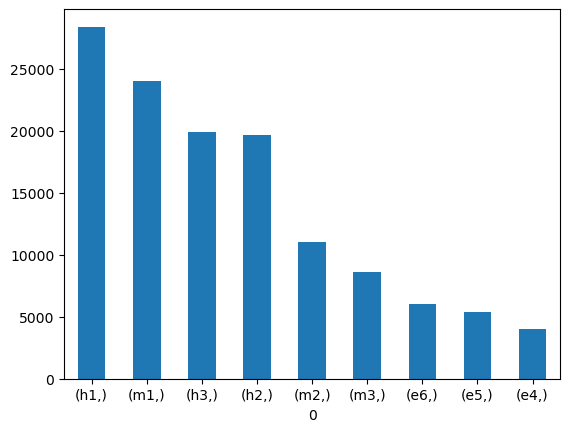

In [11]:
label_df = pd.DataFrame(gt_labels)
label_df.value_counts().plot(kind='bar')

plt.xticks(rotation=0)

plt.show()

In [12]:
labels = [
    'e4','e5','e6',
    'm1','m2','m3',
    'h1','h2','h3'
]

id2label = {}
label2id = {}

for i, item in enumerate(labels):
    id2label[i] = item
    label2id[item] = i

### processor 선택
1. 메인 모델 토크나이저
2. 한국어 기반 토크나이저 (bert-kor-base)
3. 한국어-영어 토크나이저 (ke_t5_base)

In [13]:
#메인 모델 토크나이저
processor = DonutProcessor.from_pretrained("./pretrained/main/epoch-3, batch-8, img_size-480, max_length-256, line_len/processor")
tokenizer = processor.tokenizer
    
#한국어 기반 토크나이저
#BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer_name='kor_base'

#t5
#model_name = 'KETI-AIR/ke-t5-base'
#tokenizer = processor.T5Tokenizer.from_pretrained(model_name)
#tokenizer_name='ke_t5_base'

#### 메인 모델 토크나이저

In [14]:
print(tokenizer.tokenize('다음 두 식을 모두 만족시키는 자연수'))

['▁다음', '▁두', '▁', '식을', '▁모두', '▁만', '족', '시', '키', '는', '▁자연', '수']


#### bert-kor-base

In [ ]:
#print(tokenizer.tokenize('다음 두 식을 모두 만족시키는 자연수'))

#### ke_t5_base

In [ ]:
#print(tokenizer.tokenize('다음 두 식을 모두 만족시키는 자연수'))

In [20]:
def check_for_unk(texts):
    ids = tokenizer(texts).input_ids
    tokens = [tokenizer.tokenize(x) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == tokenizer.unk_token_id:
                try:
                    example_unk_tokens.append(example_tokens[i])
                except:
                    pass

        unk_tokens += example_unk_tokens

    return unk_tokens

unk_tokens = check_for_unk(cleaned_ground_truths)

In [21]:
text_unk_tokens = list(set(unk_tokens))
print(len(text_unk_tokens))

0


In [22]:
#메인 모델 토큰 추가하기
num_added = tokenizer.add_tokens(['[CLS]', '[SEP]'])
print(num_added, "tokens added")

2 tokens added


In [23]:
X = cleaned_ground_truths[:]
y = cleaned_labels[:]


X_bert = ['[CLS] ' + str(s) + ' [SEP]' for s in X]
tokenized_texts = [tokenizer.tokenize(s) for s in X_bert]
y = [label2id[x] for x in y]

In [24]:
MAX_LEN = max([len(x) for x in tokenized_texts])
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

In [26]:

# 레이블 불균형 --> 소수의 레이블 갯수에 맞춰서 균형화

sampler=imblearn.under_sampling.RandomUnderSampler()
under_inputs_id,under_y=sampler.fit_resample(input_ids,y)

attention_masks = []

for seq in tqdm(under_inputs_id):
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    

100%|██████████| 22590/22590 [00:00<00:00, 28162.13it/s]


In [27]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(under_inputs_id,under_y, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       under_inputs_id,
                                                       random_state=42,
                                                       test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [28]:
BATCH_SIZE = 40

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [30]:
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_position_embeddings=512,
    num_labels=9
)

In [31]:
# 토크나이저 변경 후 처음 학습 할때
#model = BertForSequenceClassification(config=config)

#첫 학습 후 추가 학습할떄
model =BertForSequenceClassification.from_pretrained("kykim/bert-kor-base",num_labels=9)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model.resize_token_embeddings(len(tokenizer))

Embedding(60016, 768)

In [33]:
model = model.to(device)

In [34]:
optimizer = optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 3,
                                            num_training_steps = total_steps)

In [35]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


model.zero_grad()

for epoch in range(epochs):
    print(f'Epoch "{epoch + 1}":', end=" ")

    total_loss = 0
    model.train()  # Training 모드

    # Batch 단위로 학습
    for batch in tqdm(train_dataloader):
        
        batch = tuple(t.to(device) for t in batch) 
        b_input_ids, b_input_mask, b_labels = batch
    

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        
        

        # Loss 계산
        loss = outputs[0]
        total_loss += loss.item()
        
       
        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

        
        optimizer.step()
        scheduler.step() 

        # 모델 초기화
        model.zero_grad()

    # 평균 Loss 출력
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Average training loss: {0:.2f}".format(avg_train_loss), end=" ")
    
    
    model.eval()  # Validation 모드

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Batch 단위로 Validation 진행
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 결과 처리
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Accuracy 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Validation Accuracy 출력
    print(" Validation Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print(" Validation Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

Epoch "1": 

100%|██████████| 509/509 [01:50<00:00,  4.62it/s]


 Average training loss: 1.93  Validation Accuracy: 0.39
 Validation Accuracy: 0.39
Epoch "2": 

100%|██████████| 509/509 [01:35<00:00,  5.33it/s]


 Average training loss: 1.60  Validation Accuracy: 0.43
 Validation Accuracy: 0.43
Epoch "3": 

100%|██████████| 509/509 [01:35<00:00,  5.32it/s]


 Average training loss: 1.47  Validation Accuracy: 0.47
 Validation Accuracy: 0.47
Epoch "4": 

100%|██████████| 509/509 [01:35<00:00,  5.32it/s]


 Average training loss: 1.37  Validation Accuracy: 0.50
 Validation Accuracy: 0.50
Epoch "5": 

100%|██████████| 509/509 [01:35<00:00,  5.32it/s]


 Average training loss: 1.29  Validation Accuracy: 0.51
 Validation Accuracy: 0.51
Epoch "6": 

100%|██████████| 509/509 [01:35<00:00,  5.31it/s]


 Average training loss: 1.23  Validation Accuracy: 0.51
 Validation Accuracy: 0.51
Epoch "7": 

100%|██████████| 509/509 [01:35<00:00,  5.31it/s]


 Average training loss: 1.18  Validation Accuracy: 0.52
 Validation Accuracy: 0.52
Epoch "8": 

100%|██████████| 509/509 [01:35<00:00,  5.32it/s]


 Average training loss: 1.14  Validation Accuracy: 0.53
 Validation Accuracy: 0.53
Epoch "9": 

100%|██████████| 509/509 [01:35<00:00,  5.33it/s]


 Average training loss: 1.12  Validation Accuracy: 0.52
 Validation Accuracy: 0.52
Epoch "10": 

100%|██████████| 509/509 [01:35<00:00,  5.32it/s]


 Average training loss: 1.11  Validation Accuracy: 0.52
 Validation Accuracy: 0.52


In [33]:
model.save_pretrained('./pretrained/Sub/prepro-epoch-10, batch-40, max_length-512, kykim-BERT-model')
tokenizer.save_pretrained('./pretrained/Sub/prepro-epoch-10, batch-40, max_length-512, kykim-pre-BERT-model-tokenizer')
config.save_pretrained('./pretrained/Sub/prepro-epoch-10, batch-40, max_length-512, kykim-pre-BERT-model-config')

## Validate

For Few Sequencces

In [29]:
paths=[]
count=0
for f in tqdm(test_json_files):
    filename = os.path.basename(f)
    filepath = Path(f)
    file_str=str(filepath)
    count+=1
    if file_str.find('.zip')!= -1:
        print(file_str,count)
        pass
    else:
        paths.append(file_str)

100%|██████████| 18728/18728 [00:00<00:00, 180595.11it/s]


In [31]:
gt_test_texts = []
gt_test_labels = []

for filepath in paths:
    with open(Path(filepath),'r',encoding='utf-8') as fp:
        data = json.load(fp)
            
    label = filename.split('_')[2]
    data_series = data['segments']

    all_lines = []

    NON_OBJECT = False
        

    for d_line in data_series:
        if 'equation' not in d_line:
            NON_OBJECT = True
            break

        if '$' not in d_line['equation']:
            new_line = d_line['equation']
        else:
            equation = d_line['equation'].split('$')
            latex_line = equation[0]
            for i, e in enumerate(equation[1:]):
                if i%2 == 0:
                    latex_line += LATEX_START + e
                else:
                    latex_line += LATEX_END + e

            new_line = latex_line
        
        all_lines.append(new_line)

    if not NON_OBJECT:
        gt_test_texts += all_lines
        gt_test_labels += [label] * len(all_lines)
    else:
        pass

In [45]:
Counter(gt_test_labels)

Counter({'m3': 31720})

In [39]:
def seqs2input(seqs, labels, MAX_LEN):
    seq_bert = ['[CLS] ' + str(seq) + ' [SEP]' for seq in seqs]
    tokenized_texts = [tokenizer.tokenize(seq) for seq in seq_bert]
    labels = [label2id[x] for x in labels]

    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

    attention_masks = []

    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(labels)

In [40]:
# rand_idx = np.random.choice(range(len(gt_test_labels)),10)

tt = np.array(gt_test_texts)#[rand_idx]
tl = np.array(gt_test_labels)#[rand_idx]

test_input, test_attention_mask, test_label = seqs2input(
    tt,
    tl,
    MAX_LEN
)

100%|██████████| 31720/31720 [00:03<00:00, 8393.35it/s]


In [41]:
test_input=test_input.to(device)
test_attention_mask=test_attention_mask.to(device)
test_label=test_label.to(device)

In [ ]:
print("예측 값:", pred_label)
print("실제 값:", test_label.numpy())

For Many Sequences

In [43]:
BATCH_SIZE = 40

test_data = TensorDataset(test_input, test_attention_mask, test_label)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [44]:
model.eval()
eval_accuracy = 0
nb_eval_steps = 0

for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        pred = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask)

        logits = pred[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1


print("Test Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

 55%|█████▍    | 434/793 [01:27<01:12,  4.94it/s]


KeyboardInterrupt: 

In [45]:
model.eval()
eval_accuracy = 0
nb_eval_steps = 0

for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        pred = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask)

        logits = pred[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1


print("Test Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

100%|██████████| 815/815 [02:46<00:00,  4.90it/s]

Test Accuracy: 0.95
